In [1]:
# pip install git+https://github.com/Rich-Hall/sentinel1decoder
import matplotlib.pyplot as plt
import cmath
import numpy as np
import math as math
import os
import sentinel1decoder
import sentinel1decoder.constants
import sentinel1decoder.utilities
import logging
from scipy.interpolate import interp1d

inputfile = '/Users/robertodelprete/Documents/PyScripts/SARLens/SSFocus/Data/s1b-s6-raw-s-hh-20210919t002614-20210919t002640-028760-036ea1.dat'

decoder = sentinel1decoder.Level0Decoder(inputfile, log_level=logging.WARNING)
df = decoder.decode_metadata()
ephemeris = sentinel1decoder.utilities.read_subcommed_data(df)
ephemeris.head(2)

,X-axis position ECEF,Y-axis position ECEF,Z-axis position ECEF,X-axis velocity ECEF,Y-axis velocity ECEF,Z-axis velocity ECEF,POD Solution Data Timestamp,Q0 Attitude Quaternion,Q1 Attitude Quaternion,Q2 Attitude Quaternion,Q3 Attitude Quaternion,Omega-X Angular Rate,Omega-Y Angular Rate,Omega-Z Angular Rate,Attitude Data Timestamp
0,-1.167271e+06,-6.147292e+06,3.296218e+06,-988.135132,3713.294678,6552.580566,1.316046e+09,0.141353,-0.630249,-0.506623,-0.571086,0.000069,-0.000933,-0.000504,1.316046e+09
1,-1.167271e+06,-6.147292e+06,3.296218e+06,-988.135132,3713.294678,6552.580566,1.316046e+09,0.141353,-0.630249,-0.506623,-0.571086,0.000069,-0.000933,-0.000504,1.316046e+09


In [35]:
class SARLens:
    def __init__(self, decoder, raw, ephemeris):
        self.decoder = decoder
        self.selection = raw
        self.ephemeris = ephemeris

        self.initialize_parameters()

    def initialize_parameters(self):
        """Initialize necessary parameters as None."""
        self.iq_array = None
        self.len_range_line = None
        self.len_az_line = None
        self.range_sample_freq = None
        self.range_sample_period = None
        self.az_sample_freq = None
        self.az_sample_period = None
        self.fast_time = None
        self.slant_range = None
        self.az_freq_vals = None
        self.range_freq_vals = None

    def decode_file(self):
        """Decode the SAR data file and store the IQ data in iq_array."""
        self.iq_array = self.decoder.decode_file(self.selection)
        print("Raw data shape: ", self.iq_array.shape)
        self.len_range_line = self.iq_array.shape[1]
        self.len_az_line = self.iq_array.shape[0]

    def extract_parameters(self):
        """Extract necessary parameters from the selection dataframe."""
        self.c = sentinel1decoder.constants.speed_of_light
        self.TXPL = self.selection["Tx Pulse Length"].unique()[0]
        self.TXPSF = self.selection["Tx Pulse Start Frequency"].unique()[0]
        self.TXPRR = self.selection["Tx Ramp Rate"].unique()[0]
        self.RGDEC = self.selection["Range Decimation"].unique()[0]
        self.PRI = self.selection["PRI"].unique()[0]
        self.rank = self.selection["Rank"].unique()[0]
        self.suppressed_data_time = 320 / (8 * sentinel1decoder.constants.f_ref)
        self.range_start_time = self.selection["SWST"].unique()[0] + self.suppressed_data_time

    def calculate_wavelength(self):
        """Calculate the SAR radar wavelength."""
        self.wavelength = self.c / 5.405e9

    def calculate_sample_rates(self):
        """Calculate sample rates and periods for range and azimuth."""
        self.range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(self.RGDEC)
        self.range_sample_period = 1 / self.range_sample_freq
        self.az_sample_freq = 1 / self.PRI
        self.az_sample_period = self.PRI

    def create_fast_time_vector(self):
        """Create the fast time vector."""
        range_line_num = np.arange(self.len_range_line)
        self.fast_time = self.range_start_time + range_line_num * self.range_sample_period

    def calculate_slant_range(self):
        """Calculate the slant range vector."""
        self.slant_range = (self.rank * self.PRI + self.fast_time) * self.c / 2

    def calculate_axes(self):
        """Calculate frequency axes for range and azimuth after FFT."""
        SWL = self.len_range_line / self.range_sample_freq
        self.az_freq_vals = np.arange(-self.az_sample_freq / 2, self.az_sample_freq / 2, 1 / (self.PRI * self.len_az_line))
        self.range_freq_vals = np.arange(-self.range_sample_freq / 2, self.range_sample_freq / 2, 1)
                                         
    @staticmethod
    def d(range_freq, velocity, wavelength):
        """Calculate the D factor."""
        return math.sqrt(1 - ((wavelength ** 2 * range_freq ** 2) / (4 * velocity ** 2)))

    def calculate_spacecraft_velocity(self):
        """Calculate the spacecraft velocity."""
        self.D = np.zeros((self.len_az_line, self.len_range_line))

        ecef_vels = self.ephemeris.apply(lambda x: math.sqrt(
            x["X-axis velocity ECEF"] ** 2 + x["Y-axis velocity ECEF"] ** 2 + x["Z-axis velocity ECEF"] ** 2), axis=1)
        velocity_interp = interp1d(self.ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(),
                                   fill_value="extrapolate")
        self.x_interp = interp1d(self.ephemeris["POD Solution Data Timestamp"].unique(), self.ephemeris["X-axis position ECEF"].unique(),
                            fill_value="extrapolate")
        self.y_interp = interp1d(self.ephemeris["POD Solution Data Timestamp"].unique(), self.ephemeris["Y-axis position ECEF"].unique(),
                            fill_value="extrapolate")
        self.z_interp = interp1d(self.ephemeris["POD Solution Data Timestamp"].unique(), self.ephemeris["Z-axis position ECEF"].unique(),
                            fill_value="extrapolate")
        self.space_velocities = self.selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1)


    def calculate_positions(self):
        """Calculate x, y, and z positions for each azimuth line."""
        self.x_positions = self.selection.apply(lambda x: self.x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
        self.y_positions = self.selection.apply(lambda x: self.y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
        self.z_positions = self.selection.apply(lambda x: self.z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()

    def calculate_velocity_and_d(self):
        """Calculate spacecraft velocities and D factors for each azimuth and range line."""
        a = 6378137  # WGS84 semi-major axis
        b = 6356752.3142  # WGS84 semi-minor axis
        self.velocities = np.zeros((self.len_az_line, self.len_range_line))
        self.D = np.zeros((self.len_az_line, self.len_range_line))

        for i in range(self.len_az_line):
            H = math.sqrt(self.x_positions[i] ** 2 + self.y_positions[i] ** 2 + self.z_positions[i] ** 2)
            W = float(self.space_velocities.iloc[i]) / H
            lat = math.atan(self.z_positions[i] / self.x_positions[i])
            local_earth_rad = math.sqrt(((a ** 2 * math.cos(lat)) ** 2 + (b ** 2 * math.sin(lat)) ** 2) /
                                        ((a * math.cos(lat)) ** 2 + (b * math.sin(lat)) ** 2))
            for j in range(self.len_range_line):
                cos_beta = (local_earth_rad ** 2 + H ** 2 - self.slant_range[j] ** 2) / (2 * local_earth_rad * H)
                this_ground_velocity = local_earth_rad * W * cos_beta
                self.velocities[i, j] = math.sqrt(float(self.space_velocities.iloc[i]) * this_ground_velocity)
                self.D[i, j] = self.d(self.az_freq_vals[i], self.velocities[i, j], self.wavelength)

    def process_freq_domain_data(self):
        """Process frequency domain data."""
        self.freq_domain_data = np.zeros((self.len_az_line, self.len_range_line), dtype=complex)

        for az_index in range(self.len_az_line):
            range_line = self.iq_array[az_index, :]
            range_fft = np.fft.fft(range_line)
            self.freq_domain_data[az_index, :] = range_fft

        for range_index in range(self.len_range_line):
            az_line = self.freq_domain_data[:, range_index]
            az_fft = np.fft.fft(az_line)
            az_fft = np.fft.fftshift(az_fft)
            self.freq_domain_data[:, range_index] = az_fft


    def apply_range_filter(self):
        """Apply the range filter to the frequency domain data."""
        num_tx_vals = int(self.TXPL * self.range_sample_freq)
        tx_replica_time_vals = np.linspace(-self.TXPL / 2, self.TXPL / 2, num=num_tx_vals)
        phi1 = self.TXPSF + self.TXPRR * self.TXPL / 2
        phi2 = self.TXPRR / 2
        tx_replica = np.zeros(num_tx_vals, dtype=complex)
        for i in range(num_tx_vals):
            tx_replica[i] = cmath.exp(2j * cmath.pi * (phi1 * tx_replica_time_vals[i] + phi2 * tx_replica_time_vals[i] ** 2))

        range_filter = np.zeros(self.len_range_line, dtype=complex)
        index_start = np.ceil((self.len_range_line - num_tx_vals) / 2) - 1
        index_end = num_tx_vals + np.ceil((self.len_range_line - num_tx_vals) / 2) - 2
        range_filter[int(index_start):int(index_end + 1)] = tx_replica

        range_filter = np.fft.fft(range_filter)
        range_filter = np.conjugate(range_filter)

        for az_index in range(self.len_az_line):
            self.freq_domain_data[az_index, :] = self.freq_domain_data[az_index, :] * range_filter
    
    
    def apply_rcmc_filter(self):
        """Apply the RCMC filter to the frequency domain data."""
        rcmc_filt = np.zeros(self.len_range_line, dtype=complex)
        range_freq_vals = np.linspace(-self.range_sample_freq / 2, self.range_sample_freq / 2, num=self.len_range_line)
        for az_index in range(self.len_az_line):
            rcmc_filt = np.zeros(self.len_range_line, dtype=complex)
            for range_index in range(self.len_range_line):
                rcmc_shift = self.slant_range[0] * ((1 / self.D[az_index, range_index]) - 1)
                rcmc_filt[range_index] = cmath.exp(4j * cmath.pi * range_freq_vals[range_index] * rcmc_shift / self.c)
            self.freq_domain_data[az_index, :] = self.freq_domain_data[az_index, :] * rcmc_filt

        self.range_doppler_data = np.zeros((self.len_az_line, self.len_range_line), dtype=complex)
        for range_line_index in range(self.len_az_line):
            ifft = np.fft.ifft(self.freq_domain_data[range_line_index, :])
            ifft_sorted = np.fft.ifftshift(ifft)
            self.range_doppler_data[range_line_index, :] = ifft_sorted

    def apply_azimuth_filter(self):
        """Apply the azimuth filter and create the compressed data."""
        self.az_compressed_data = np.zeros((self.len_az_line, self.len_range_line), 'complex')

        for az_line_index in range(self.len_range_line):
            d_vector = np.zeros(self.len_az_line)
            
            this_az_filter = np.zeros(self.len_az_line, 'complex')
            for i in range(len(self.az_freq_vals) - 2):  # -1
                this_az_filter[i] = cmath.exp(
                    (4j * cmath.pi * self.slant_range[i] * self.D[i, az_line_index]) / self.wavelength)
            result = self.range_doppler_data[:, az_line_index] * this_az_filter[:]
            result = np.fft.ifft(result)
            self.az_compressed_data[:, az_line_index] = result

    def plot_img(self):
        # Plot final image
        plt.figure(figsize=(16,100))
        plt.title("Sentinel-1 Processed SAR Image")
        plt.imshow(abs(self.az_compressed_data[:,:]), vmin=0, vmax=2000, origin='lower')
        plt.xlabel("Down Range (samples)")
        plt.ylabel("Cross Range (samples)")
        plt.show()

    def process(self):
        """Main processing method."""
        self.decode_file()
        self.extract_parameters()
        self.calculate_wavelength()
        self.calculate_sample_rates()
        self.create_fast_time_vector()
        self.calculate_slant_range()
        self.calculate_axes()
        self.calculate_spacecraft_velocity()
        self.calculate_positions()
        self.calculate_velocity_and_d()
        self.process_freq_domain_data()
        self.apply_range_filter()
        self.apply_rcmc_filter()
        self.apply_azimuth_filter()
        self.plot_img()




# BAQ

BAQ (Binary Amplitude Quantization) mode is a specific data quantization technique used in Synthetic Aperture Radar (SAR) systems to compress and reduce the amount of data generated during the radar imaging process. SAR systems produce high-resolution images of the Earth's surface by transmitting radar signals and then processing the reflected signals (echoes) from the ground. This process generates a large volume of data, which can be challenging to manage, store, and transmit.

BAQ mode reduces the amount of data by quantizing the amplitude of the received radar echoes. This is achieved by converting the continuous amplitude values of the radar echoes into discrete levels or "bins." Each amplitude value is then represented by a binary code, which requires fewer bits than the original continuous amplitude value.

The main advantage of using BAQ mode in SAR systems is the significant reduction in data size, which simplifies data handling, storage, and transmission. However, quantization can introduce some loss of information, which may affect the image quality to a certain extent. The trade-off between data reduction and image quality depends on the number of quantization levels (or bits) used. More quantization levels result in better image quality but lower data reduction, whereas fewer quantization levels yield higher data reduction but potentially lower image quality.

In summary, BAQ mode is a data quantization technique used in SAR systems to reduce the amount of data generated during the radar imaging process. This technique allows for more manageable data handling, storage, and transmission at the expense of some loss in image quality, depending on the number of quantization levels used.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df["BAQ Mode"].to_list())
plt.xlim([0,1000])
plt.title('BAQ')
plt.show()

# Processing:

In [64]:
selection = df.iloc[10:10000]  # from 61 it works
# selection.iloc[60:62].T

In [65]:
# processor = SARLens(decoder, selection, ephemeris)
# processor.decode_file()
# processor.extract_parameters()
# processor.calculate_wavelength()
# processor.calculate_sample_rates()
# processor.create_fast_time_vector()
# processor.calculate_slant_range()
# processor.calculate_axes()
# processor.calculate_spacecraft_velocity()
# processor.calculate_positions()
# processor.calculate_velocity_and_d()
# processor.process_freq_domain_data()
# processor.apply_range_filter()
# processor.apply_rcmc_filter()
# processor.apply_azimuth_filter()
# processor.plot_img()

# # processor.process()

In [67]:
processor = SARLens(decoder, selection, ephemeris)

In [68]:
import time

print('Decode File:')
t0 = time.time()
processor.decode_file()
t1 = time.time()
print('Execution time:', t1 - t0)

print('extract_parameters:')
t2 = time.time()
processor.extract_parameters()
t3 = time.time()
print('Execution time:', t3 - t2)

print('calculate_wavelength:')
t4 = time.time()
processor.calculate_wavelength()
t5 = time.time()
print('Execution time:', t5 - t4)

print('calculate_sample_rates:')
t6 = time.time()
processor.calculate_sample_rates()
t7 = time.time()
print('Execution time:', t7 - t6)

print('create_fast_time_vector:')
t8 = time.time()
processor.create_fast_time_vector()
t9 = time.time()
print('Execution time:', t9 - t8)

print('calculate_slant_range:')
t10 = time.time()
processor.calculate_slant_range()
t11 = time.time()
print('Execution time:', t11 - t10)

print('calculate_axes:')
t12 = time.time()
processor.calculate_axes()
t13 = time.time()
print('Execution time:', t13 - t12)

print('calculate_spacecraft_velocity:')
t14 = time.time()
processor.calculate_spacecraft_velocity()
t15 = time.time()
print('Execution time:', t15 - t14)

print('calculate_positions:')
t16 = time.time()
processor.calculate_positions()
t17 = time.time()
print('Execution time:', t17 - t16)

print('calculate_velocity_and_d:')
t18 = time.time()
processor.calculate_velocity_and_d()
t19 = time.time()
print('Execution time:', t19 - t18)

print('process_freq_domain_data:')
t20 = time.time()
processor.process_freq_domain_data()
t21 = time.time()
print('Execution time:', t21 - t20)


Decode File:
Raw data shape:  (9990, 2454)
Execution time: 119.0665020942688
extract_parameters:
Execution time: 0.00302886962890625
calculate_wavelength:
Execution time: 2.3603439331054688e-05
calculate_sample_rates:
Execution time: 2.5987625122070312e-05
create_fast_time_vector:
Execution time: 5.91278076171875e-05
calculate_slant_range:
Execution time: 0.0004930496215820312
calculate_axes:
Execution time: 0.10412907600402832
calculate_spacecraft_velocity:
Execution time: 0.33909082412719727
calculate_positions:
Execution time: 0.9563548564910889
calculate_velocity_and_d:
Execution time: 147.22665214538574
process_freq_domain_data:
Execution time: 2.159191131591797


In [70]:
print('apply_range_filter:')
t0 = time.time()
processor.apply_range_filter()
t1 = time.time()
print('Execution time:', t1 - t0)

print('apply_rcmc_filter:')
t2 = time.time()
processor.apply_rcmc_filter()
t3 = time.time()
print('Execution time:', t3 - t2)

# print('apply_azimuth_filter:')
# t4 = time.time()
# processor.apply_azimuth_filter()
# t5 = time.time()
# print('Execution time:', t5 - t4)

# print('plot_img:')
# t6 = time.time()
# processor.plot_img()
# t7 = time.time()
# print('Execution time:', t7 - t6)

apply_range_filter:
Execution time: 0.2760319709777832
apply_rcmc_filter:
Execution time: 22.526304006576538


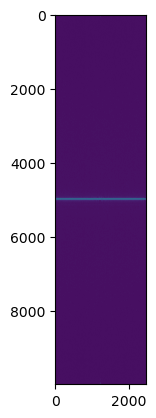

In [71]:
plt.imshow(abs(processor.range_doppler_data))

In [73]:
processor.len_az_line


"""Apply the azimuth filter and create the compressed data."""
processor.az_compressed_data = np.zeros((processor.len_az_line, processor.len_range_line), 'complex')

for az_line_index in range(processor.len_range_line):
       try:
              # d_vector = np.zeros(processor.len_az_line)

              this_az_filter = np.zeros(processor.len_az_line, 'complex')
              # for ii in range(len(processor.az_freq_vals) - 1):  # -1
              for ii in range(len(processor.slant_range) - 1):  # -1
                     this_az_filter[ii] = cmath.exp((4j * cmath.pi * processor.slant_range[ii] * processor.D[ii, az_line_index]) / processor.wavelength)
       
       except IndexError:
              print('Error')
              print('len_processor.az_freq_vals:',len(processor.az_freq_vals))
              print('i:',ii)
              print('slant_range.shape:',processor.slant_range.shape)
              print('slant_range.shape:',processor.D.shape)
              print('az_line_index:',az_line_index)

       result = processor.range_doppler_data[:, az_line_index] * this_az_filter[:]
       result = np.fft.ifft(result)
       processor.az_compressed_data[:, az_line_index] = result

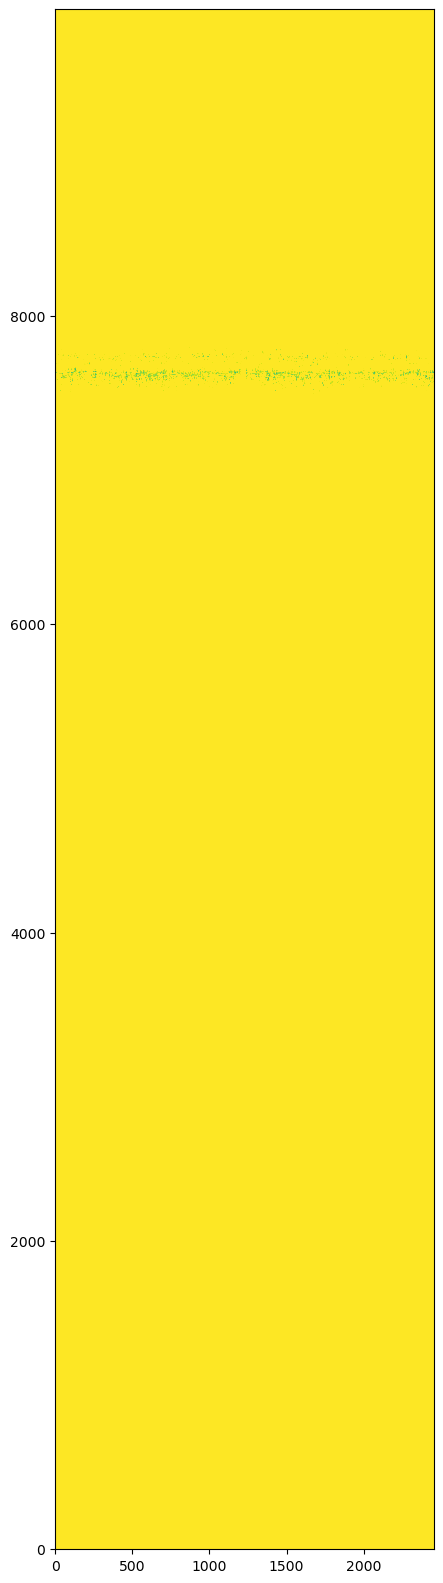

In [84]:
plt.figure(figsize=(20,20))
plt.imshow(abs(processor.az_compressed_data), vmin=0, vmax=2000, origin='lower')
plt.show()

In [85]:
# SOURCE CODE

iq_array = decoder.decode_file(selection)
print("Raw data shape: ", iq_array.shape)
# Image sizes
len_range_line = iq_array.shape[1]
len_az_line = iq_array.shape[0]

# Extract necessary parameters, see both reference documents.
# All necessary parameters are included into the dataframe
c = sentinel1decoder.constants.speed_of_light
TXPL = selection["Tx Pulse Length"].unique()[0]
print("Tx Pulse length", TXPL)
TXPSF = selection["Tx Pulse Start Frequency"].unique()[0]
print("Tx Pulse Start Freq", TXPSF)
TXPRR = selection["Tx Ramp Rate"].unique()[0]
print("Tx Ramp Rate", TXPRR)
RGDEC = selection["Range Decimation"].unique()[0]
print("Range Decimation", RGDEC)
PRI = selection["PRI"].unique()[0]
print("PRI", RGDEC)
rank = selection["Rank"].unique()[0]
print("Rank", rank)
suppressed_data_time = 320/(8*sentinel1decoder.constants.f_ref)  # see pag. 82 of the reference document (Airbus)
print(suppressed_data_time)
range_start_time = selection["SWST"].unique()[0] + suppressed_data_time
wavelength = c / 5.405e9

# Sample rates
range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
range_sample_period = 1 / range_sample_freq
az_sample_freq = 1 / PRI
az_sample_period = PRI

# Fast time vector [s] - defines the time axis along the fast time direction
range_line_num = [i for i in range(len_range_line)]
fast_time = [range_start_time + i * range_sample_period for i in range_line_num]


# Slant range vector - defines R0, the range of the closest approach for each range cell (i.e. the slant range when
# the radar is closest to the target)
slant_range = [(rank * PRI + t) * c / 2 for t in fast_time]

# Axes - defines the frequency axes in each direction after FFT
SWL = len_range_line / range_sample_freq
az_freq_vals = np.arange(-az_sample_freq / 2, az_sample_freq / 2, 1 / (PRI * len_az_line))
range_freq_vals = np.arange(-range_sample_freq / 2, range_sample_freq / 2, 1 / SWL)


# We need two parameters which vary over range and azimuth, so we're going to loop over these once
# D is the cosine of the instantaneous squint angle and is defined by the letter D in most literature
# Define a function to calculate D, then apply it inside the loop
def d(range_freq, velocity):
    return math.sqrt(1 - ((wavelength ** 2 * range_freq ** 2) / (4 * velocity ** 2)))


D = np.zeros((len_az_line, len_range_line))

# Spacecraft velocity - numerical calculation of the effective spacecraft velocity
ecef_vels = ephemeris.apply(lambda x: math.sqrt(
    x["X-axis velocity ECEF"] ** 2 + x["Y-axis velocity ECEF"] ** 2 + x["Z-axis velocity ECEF"] ** 2), axis=1)
velocity_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(),
                           fill_value="extrapolate")
x_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["X-axis position ECEF"].unique(),
                    fill_value="extrapolate")
y_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["Y-axis position ECEF"].unique(),
                    fill_value="extrapolate")
z_interp = interp1d(ephemeris["POD Solution Data Timestamp"].unique(), ephemeris["Z-axis position ECEF"].unique(),
                    fill_value="extrapolate")
space_velocities = selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1)

x_positions = selection.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
y_positions = selection.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()
z_positions = selection.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_list()

a = 6378137 # WGS84 semi major axis
b = 6356752.3142 # WGS84 semi minor axis
velocities = np.zeros((len_az_line, len_range_line))

# Now loop over range and azimuth, and calculate spacecraft velocity and D
for i in range(len_az_line):
    H = math.sqrt(x_positions[i]**2 + y_positions[i]**2 + z_positions[i]**2)
    W = float(space_velocities.iloc[i])/H
    lat = math.atan(z_positions[i] / x_positions[i])
    local_earth_rad = math.sqrt(((a**2 * math.cos(lat))**2 + (b**2 * math.sin(lat))**2) / ((a * math.cos(lat))**2 + (b * math.sin(lat))**2))
    for j in range(len_range_line):
        cos_beta = (local_earth_rad**2 + H**2 - slant_range[j]**2) / (2 * local_earth_rad * H)
        this_ground_velocity = local_earth_rad * W * cos_beta
        velocities[i, j] = math.sqrt(float(space_velocities.iloc[i]) * this_ground_velocity)
        D[i, j] = d(az_freq_vals[i], velocities[i, j])

freq_domain_data = np.zeros((len_az_line, len_range_line), dtype=complex)

for az_index in range(len_az_line):
    range_line = iq_array[az_index, :]
    range_fft = np.fft.fft(range_line)
    freq_domain_data[az_index, :] = range_fft

for range_index in range(len_range_line):
    az_line = freq_domain_data[:, range_index]
    az_fft = np.fft.fft(az_line)
    az_fft = np.fft.fftshift(az_fft)
    freq_domain_data[:, range_index] = az_fft

# Create range filter
num_tx_vals = int(TXPL*range_sample_freq)
tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
phi1 = TXPSF + TXPRR*TXPL/2
phi2 = TXPRR/2
tx_replica = np.zeros(num_tx_vals, dtype=complex)
for i in range(num_tx_vals):
    tx_replica[i] = cmath.exp(2j * cmath.pi * (phi1*tx_replica_time_vals[i] + phi2*tx_replica_time_vals[i]**2))

range_filter = np.zeros(len_range_line, dtype=complex)
index_start = np.ceil((len_range_line-num_tx_vals)/2)-1
index_end = num_tx_vals+np.ceil((len_range_line-num_tx_vals)/2)-2
range_filter[int(index_start):int(index_end+1)] = tx_replica

range_filter = np.fft.fft(range_filter)
range_filter = np.conjugate(range_filter)

for az_index in range(len_az_line):
    freq_domain_data[az_index, :] = freq_domain_data[az_index, :]*range_filter


rcmc_filt = np.zeros(len_range_line, dtype=complex)
range_freq_vals = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)
for az_index in range(len_az_line):
    rcmc_filt = np.zeros(len_range_line, dtype=complex)
    for range_index in range(len_range_line):
        rcmc_shift = slant_range[0]*((1/D[az_index, range_index])-1)
        rcmc_filt[range_index] = cmath.exp(4j * cmath.pi * range_freq_vals[range_index] * rcmc_shift / c)
    freq_domain_data[az_index, :] = freq_domain_data[az_index, :]*rcmc_filt

range_doppler_data = np.zeros((len_az_line, len_range_line), dtype=complex)
for range_line_index in range(len_az_line):
    ifft = np.fft.ifft(freq_domain_data[range_line_index, :])
    ifft_sorted = np.fft.ifftshift(ifft)
    range_doppler_data[range_line_index, :] = ifft_sorted



Raw data shape:  (9990, 2454)
Tx Pulse length 5.109935242723139e-05
Tx Pulse Start Freq -21094036.48895405
Tx Ramp Rate 825635554407.1796
Range Decimation 9
PRI 9
Rank 10
1.0656799254897057e-06
(9990,)
2454
(9990, 2454)
(9990,)


IndexError: list index out of range

In [89]:
# Create azimuth filter
az_compressed_data = np.zeros((len_az_line, len_range_line), 'complex')

for az_line_index in range(len_range_line):
    d_vector = np.zeros(len_az_line)
    this_az_filter = np.zeros(len_az_line, 'complex')
    print('Azimuth_Filter_shape:',this_az_filter.shape)
    print(len(slant_range))
    print(D.shape)
    print(az_freq_vals.shape)
    print('Azimuth Freq Vals:',len(az_freq_vals)-1)
    for i in range(len(az_freq_vals)-1):  # -1
        this_az_filter[i] = cmath.exp((4j * cmath.pi * slant_range[i] * D[i, az_line_index]) / wavelength)
    result = range_doppler_data[:, az_line_index] * this_az_filter[:]
    result = np.fft.ifft(result)
    az_compressed_data[:, az_line_index] = result

# Plot final image
plt.figure(figsize=(16,100))
plt.title("Sentinel-1 Processed SAR Image")
plt.imshow(abs(az_compressed_data[:,:]), vmin=0, vmax=2000, origin='lower')
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()

Azimuth_Filter_shape: (9990,)
2454
(9990, 2454)
(9990,)
Azimuth Freq Vals: 9989


IndexError: list index out of range